In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
# looks weird, but makes pixel values between -1 and +1
# assume they are transformed from (0, 1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [7]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2
  return out

In [11]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]


    ###########################
    ### Train discriminator ###
    ###########################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #######################
    ### Train generator ###
    #######################

    # do it twice:
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels!
      g_loss = criterion(fake_outputs, ones)

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  ### print and save things ###
  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # PyTorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0, d_loss: 0.7145963907241821, g_loss: 0.62181556224823
Epoch: 1, d_loss: 0.681763768196106, g_loss: 0.6702771186828613
Epoch: 2, d_loss: 0.6804559230804443, g_loss: 0.6687461733818054
Epoch: 3, d_loss: 0.6771694421768188, g_loss: 0.6835137009620667
Epoch: 4, d_loss: 0.6816089153289795, g_loss: 0.690824568271637
Epoch: 5, d_loss: 0.6770268678665161, g_loss: 0.7107158303260803
Epoch: 6, d_loss: 0.6879221200942993, g_loss: 0.7099282741546631
Epoch: 7, d_loss: 0.6807937622070312, g_loss: 0.733913242816925
Epoch: 8, d_loss: 0.6870794296264648, g_loss: 0.7179757952690125
Epoch: 9, d_loss: 0.6825733184814453, g_loss: 0.6954167485237122
Epoch: 10, d_loss: 0.6863313913345337, g_loss: 0.7139776349067688
Epoch: 11, d_loss: 0.6909329295158386, g_loss: 0.6867020130157471
Epoch: 12, d_loss: 0.6888840198516846, g_loss: 0.7887324690818787
Epoch: 13, d_loss: 0.6861143112182617, g_loss: 0.7205624580383301
Epoch: 14, d_loss: 0.6813021898269653, g_loss: 0.7036964297294617
Epoch: 15, d_loss: 0.7002

Epoch: 125, d_loss: 0.6463806629180908, g_loss: 0.8553693294525146
Epoch: 126, d_loss: 0.5876269340515137, g_loss: 0.7881030440330505
Epoch: 127, d_loss: 0.727799654006958, g_loss: 1.2763792276382446
Epoch: 128, d_loss: 0.640536904335022, g_loss: 1.1861897706985474
Epoch: 129, d_loss: 0.6097726225852966, g_loss: 0.9004469513893127
Epoch: 130, d_loss: 0.6774934530258179, g_loss: 0.708583414554596
Epoch: 131, d_loss: 0.6142501831054688, g_loss: 0.9396054744720459
Epoch: 132, d_loss: 0.608609676361084, g_loss: 0.9411613941192627
Epoch: 133, d_loss: 0.5990912318229675, g_loss: 0.808363139629364
Epoch: 134, d_loss: 0.575965940952301, g_loss: 0.8709351420402527
Epoch: 135, d_loss: 0.5952774882316589, g_loss: 1.148632526397705
Epoch: 136, d_loss: 0.6127074956893921, g_loss: 1.0807968378067017
Epoch: 137, d_loss: 0.5830175876617432, g_loss: 1.1577118635177612
Epoch: 138, d_loss: 0.5856195688247681, g_loss: 0.8624690175056458
Epoch: 139, d_loss: 0.6360878944396973, g_loss: 0.717622697353363
Epo

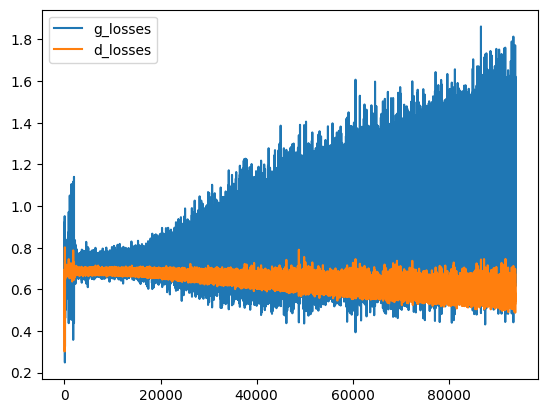

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [9]:
#!conda install -c conda-forge skimage
!conda install -c conda-forge scikit-image -y

Solving environment: done

## Package Plan ##

  environment location: /Users/Z0094BV/miniconda3

  added / updated specs:
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.3               |       hcec6c5f_0          61 KB
    brunsli-0.1                |       h046ec9c_0         179 KB  conda-forge
    cfitsio-3.470              |       h01dc385_7         1.3 MB  conda-forge
    charls-2.2.0               |       h23ab428_0          82 KB
    cloudpickle-2.2.1          |     pyhd8ed1ab_0          27 KB  conda-forge
    cytoolz-0.12.0             |   py39ha30fb19_1         350 KB  conda-forge
    dask-core-2023.1.1         |     pyhd8ed1ab_0         809 KB  conda-forge
    fsspec-2023.4.0            |     pyh1a96a4e_0         109 KB  conda-forge
    imagecodecs-2021.8.26      |   py39h8a96914_2         6.0 MB
    imageio-2.27.0             |     pyh24c5eb1_0

partd-1.3.0          | 18 KB     | ##################################### | 100% 




zfp-0.5.5            | 172 KB    | ##########3                           |  28% 

scipy-1.8.1          | 22.0 MB   |                                       |   0% 


zstd-1.5.2           | 399 KB    | ##9                                   |   8% 





dask-core-2023.1.1   | 809 KB    | 7                                     |   2% 






openjpeg-2.5.0       | 322 KB    | #8                                    |   5% 

scipy-1.8.1          | 22.0 MB   | 4                                     |   1% 




pyyaml-6.0           | 166 KB    | ##################################### | 100% 




pyyaml-6.0           | 166 KB    | ##################################### | 100% 








zfp-0.5.5            | 172 KB    | ##################################### | 100% 









zfp-0.5.5            | 172 KB    | ##################################### | 100% 










imageio-2.27.0       | 3.1 MB    | 1                   

cytoolz-0.12.0       | 350 KB    | #6                                    |   5% 






















 ... (more hidden) ...







imagecodecs-2021.8.2 | 6.0 MB    | ###############6                      |  42% 













cfitsio-3.470        | 1.3 MB    | ##################################### | 100% 













cfitsio-3.470        | 1.3 MB    | ##################################### | 100% 

scipy-1.8.1          | 22.0 MB   | ######################3               |  60% 

















scikit-image-0.20.0  | 9.6 MB    | ##################9                   |  51% 




















charls-2.2.0         | 82 KB     | ##################################### | 100% 




















charls-2.2.0         | 82 KB     | ##################################### | 100% 



















pywavelets-1.4.1     | 3.4 MB    | ##################################### | 100% 



















pywavelets-1.4.1     | 3.4 MB    | ##################################### | 100% 







imagecode

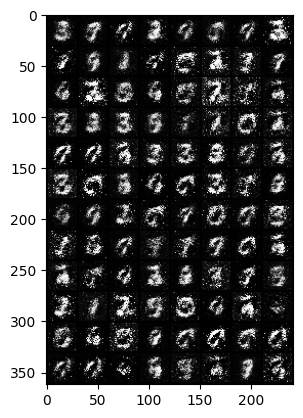

In [12]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

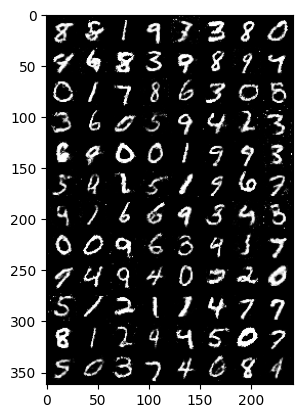

In [13]:
a = imread('gan_images/50.png')
plt.imshow(a)

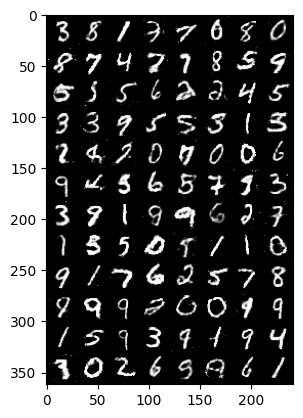

In [14]:
a = imread('gan_images/100.png')
plt.imshow(a)

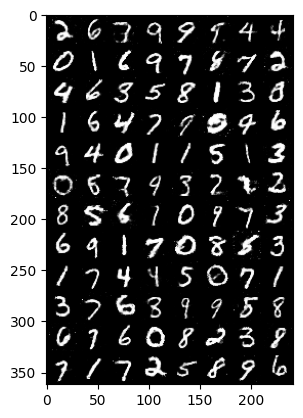

In [15]:
a = imread('gan_images/150.png')
plt.imshow(a)

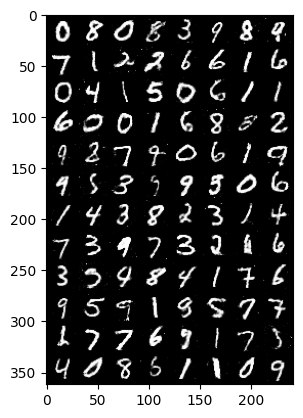

In [16]:
a = imread('gan_images/200.png')
plt.imshow(a)